In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from face_model import FaceModel
from individual import Individual
from render_model import RenderModel
from bfm_lmks import BFM_lmks_v
import pickle

ModuleNotFoundError: No module named 'modelling'

In [3]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

In [4]:
class Model(nn.Module):
    def __init__(self, device):
        super(Model, self).__init__()
        self.device = device
        self.face_model = FaceModel(device)
        self.individual = Individual(device)
        self.render_model = RenderModel(device)
        self.content_weight = 2000
        self.lm_weight = 1.0
        self.reg_weight = 0.002

    def compute_projected_lmks(self, mesh, R, T):
        """ Compute the (x, y) positions of the 68 face landmarks on the screen space """

        lmks_verts = mesh.verts_padded()[:, BFM_lmks_v, :]
        camera = self.render_model.renderer.rasterizer.cameras
        proj_lmks = camera.transform_points_screen(lmks_verts,
                                                   torch.tensor([[611.0, 430.0]]).to(device),
                                                   R=R, 
                                                   T=T)
        return proj_lmks[0, :, :2]

    def forward(self):
        mesh_to_render = self.face_model.compute_face()
        R , T = self.render_model.compute_rigid_transformation()

        image = self.render_model.renderer(meshes_world=mesh_to_render, R=R, T=T)
        proj_lmks = self.compute_projected_lmks(mesh_to_render, R, T)

        # Calculate the silhouette loss
        loss_content = self.content_weight * (1/torch.sum(self.individual.image_mask)) * torch.sum(((image[0,:,:,:3] - self.individual.source_image)*self.individual.image_mask.unsqueeze(-1)) ** 2)
        loss_lm = self.lm_weight*(1/68.0)*torch.sum(torch.norm(proj_lmks - self.individual.image_lmks[...,:2], dim=1) ** 2)
        loss_reg = self.reg_weight * self.face_model.compute_loss_reg()
        print(f"loss_content: {loss_content}")
        print(f"loss_lm: {loss_lm}")
        print(f"loss_reg: {loss_reg}")
        total_loss = loss_content + loss_lm + loss_reg
        #total_loss = loss_lm + loss_reg
        #total_loss = loss_lm

        return total_loss, image

In [5]:
# Initialize a model using the renderer, mesh and reference image
model = Model(device).to(device)

In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
checkpoint = torch.load('people/WF-029/params.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

RuntimeError: Error(s) in loading state_dict for Model:
	Unexpected key(s) in state_dict: "render_model.camera.T", "render_model.renderer.rasterizer.cameras.T", "render_model.renderer.shader.cameras.T". 

In [7]:
loop = tqdm(range(100))
for i in loop:
    optimizer.zero_grad()
    loss, _ = model()
    loss.backward()
    optimizer.step()
    #print(loss)
    loop.set_description('Optimizing (loss %.4f)' % loss.data)
    
    #if loss.item() < 2:
    #    break

<00:23,  6.62it/s]loss_content: 11.182507313413767
loss_lm: 4.001703262329102
loss_reg: 0.18766558170318604
loss_content: 11.565428317606429
loss_lm: 4.0033159255981445
loss_reg: 0.18772168457508087
Optimizing (loss 15.7294):  85%|████████▍ | 848/1000 [02:08<00:22,  6.61it/s]loss_content: 11.435624146779052
loss_lm: 3.9736220836639404
loss_reg: 0.18779993057250977
loss_content: 11.489852885310588
loss_lm: 4.051669597625732
loss_reg: 0.18785420060157776
Optimizing (loss 15.4399):  85%|████████▌ | 850/1000 [02:08<00:22,  6.62it/s]loss_content: 11.473302175739144
loss_lm: 3.9526350498199463
loss_reg: 0.18788671493530273
loss_content: 11.350966074549849
loss_lm: 3.9009501934051514
loss_reg: 0.18794897198677063
Optimizing (loss 15.4944):  85%|████████▌ | 852/1000 [02:08<00:22,  6.64it/s]loss_content: 11.12742621921204
loss_lm: 3.977161169052124
loss_reg: 0.18801942467689514
loss_content: 11.391476117342796
loss_lm: 3.914823293685913
loss_reg: 0.1880732774734497
Optimizing (loss 15.7902):  8

In [7]:
"""torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, 'people/WF-029/params.pth')"""

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
loss_content: 12.029826381061023
loss_lm: 3.7292821407318115
loss_reg: 0.19809351861476898


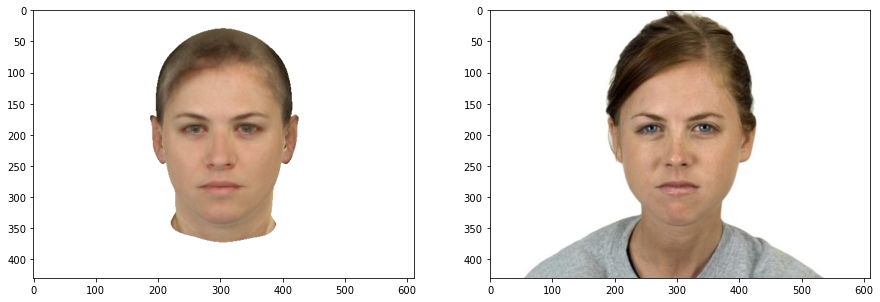

In [7]:
_, image_init = model()
_, axs = plt.subplots(1, 2, figsize=(15, 15))
axs = axs.flatten()
axs[0].imshow(image_init[0, ..., :3].detach().cpu().numpy())
axs[1].imshow(model.individual.source_image.detach().cpu())
plt.show()

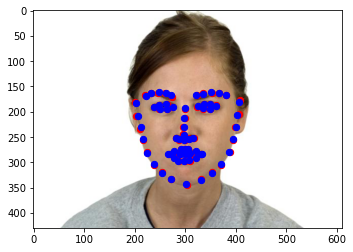

In [9]:
mesh_to_render = model.face_model.compute_face()
R , T = model.render_model.compute_rigid_transformation()
proj_lmks = model.compute_projected_lmks(mesh_to_render, R, T).detach().cpu()
implot = plt.imshow(model.individual.source_image.detach().cpu())
image_lmks = model.individual.image_lmks.detach().cpu()
plt.scatter(x=image_lmks[:,0], y=image_lmks[:,1], c='r', s=40)
plt.scatter(x=proj_lmks[:,0], y=proj_lmks[:,1], c='b', s=40)
plt.show()

In [58]:
model.render_model.camera.scale_xyz

tensor([[0.4373, 0.6211, 1.0000]], device='cuda:0',
       grad_fn=<AsStridedBackward>)